In [10]:
#---------- IMPORTS -----------

#Simple Imports
import cv2
import os
import pickle
import numpy as np
import tensorflow as tf
import random
import datetime
import glob

#Tensorflow/Keras Imports
import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorboard import program

#Aux Imports
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix,roc_curve, auc, precision_recall_curve

In [2]:
#Creacion del modelo preentrenado en CNN

def build_model(pretrained): #Las capas internas se apilan de manera vertical
    model = Sequential([
        pretrained, #La construccion del modelo es preentrenado
        layers.GlobalAveragePooling2D(), #Las capas se comunicaran de manera binaria
        layers.Dense(1, activation='sigmoid') #La salida será binaria
    ])
    
    model.compile(
        loss='binary_crossentropy', #Mas adecuado para la clasificacion binaria 
        optimizer=Adam(), #Version avanzada de SGD
        metrics=['accuracy']
    )
    return model

# Generator

In [2]:
#Ruta de nuestro dataset
base_path = '../dataset/real-vs-fake/'
real_path = '../dataset/real-vs-fake/test/real'
fake_path = '../dataset/real-vs-fake/test/fake'

#Conjuntos de Imagenes
real_images = [os.path.join(real_path, img) for img in os.listdir(real_path)]
fake_images = [os.path.join(fake_path, img) for img in os.listdir(fake_path)]

In [4]:
#Pick de fotos de entreno

#Normalizamos los valores de los pixeles, dividimos /255 para obtener los valores de RGB entre 0 y 1
image_gen = ImageDataGenerator(rescale=1./255.)

train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224), #Redimension de las imagenes
    color_mode='grayscale',
    batch_size=64, #Tamaño de lote

    class_mode='binary'
)

print("Train classes: ", os.listdir(base_path + 'train/'))

Found 50000 images belonging to 2 classes.
Train classes:  ['fake', 'real']


In [5]:
#Pick de fotos de validacion
image_gen1 = ImageDataGenerator(rescale=1./255.)

valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=64,
    class_mode='binary'
)

print("Train classes: ", os.listdir(base_path + 'valid/'))


Found 5000 images belonging to 2 classes.
Train classes:  ['fake', 'real']


# Short EDA - Exploratory Data Analysis

In [6]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(base_path): 
    for label in os.listdir(base_path + "/" + folder):
        for img in glob.glob(base_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [7]:
images_df = pd.DataFrame(images_df)

In [8]:
images_df

,folder,image_path,label
0,test,../dataset/real-vs-fake//test/fake\QS994V4M2T.jpg,fake
1,test,../dataset/real-vs-fake//test/fake\QSB3LIBHML.jpg,fake
2,test,../dataset/real-vs-fake//test/fake\QSE7B3Z850.jpg,fake
3,test,../dataset/real-vs-fake//test/fake\QSFUPGKK87.jpg,fake
4,test,../dataset/real-vs-fake//test/fake\QSIGUG4X1W.jpg,fake
...,...,...,...
59995,valid,../dataset/real-vs-fake//valid/real\69960.jpg,real
59996,valid,../dataset/real-vs-fake//valid/real\69963.jpg,real
59997,valid,../dataset/real-vs-fake//valid/real\69987.jpg,real
59998,valid,../dataset/real-vs-fake//valid/real\69996.jpg,real


### Labels Distribution

In [9]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

In [10]:
real_grouped_df.size()

folder
test      2500
train    25000
valid     2500
dtype: int64

In [11]:
fake_grouped_df.size()

folder
test      2500
train    25000
valid     2500
dtype: int64

In [12]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i], cmap='gray')
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else:
            plt.title("Real")

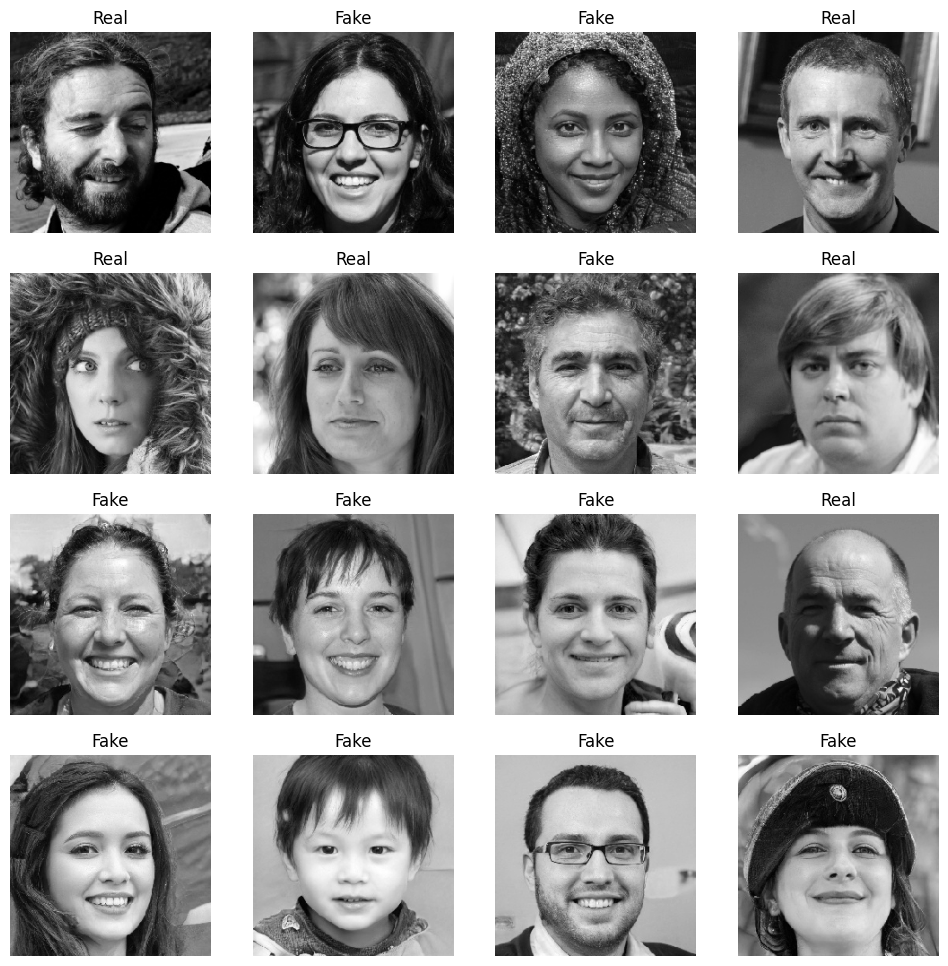

In [13]:
img,lbl = next(train_flow)
plot_images(img,lbl)

In [14]:
#Visualizacion de la normalizacion de las imagenes
for img, label in train_flow:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.8705883 ]
  [0.8745099 ]
  [0.8588236 ]
  ...
  [0.86666673]
  [0.882353  ]
  [0.8980393 ]]

 [[0.86666673]
  [0.86274517]
  [0.85098046]
  ...
  [0.86666673]
  [0.882353  ]
  [0.8941177 ]]

 [[0.86274517]
  [0.85098046]
  [0.83921576]
  ...
  [0.86666673]
  [0.87843144]
  [0.8862746 ]]

 ...

 [[0.79215693]
  [0.8000001 ]
  [0.8000001 ]
  ...
  [0.49411768]
  [0.45098042]
  [0.5058824 ]]

 [[0.7803922 ]
  [0.79215693]
  [0.79215693]
  ...
  [0.46274513]
  [0.48235297]
  [0.46274513]]

 [[0.7725491 ]
  [0.78823537]
  [0.79215693]
  ...
  [0.48235297]
  [0.4784314 ]
  [0.36862746]]]
Label:  0.0


In [15]:
for img, label in train_flow:
    print(img.shape)
    print(label.shape)
    break

(64, 224, 224, 1)
(64,)


# Train Model DenseNet   

In [16]:
#Creacion de modelo DenseNet121
densenet = DenseNet121( #Modelo preentrenado de 121 capas
    weights=None, #No utilizamos pesos
    include_top=False, #No utilizamos fully_connected
    input_shape=(224,224,1) #Forma de entrada de las imagenes
)
#Construccion de modelo secuencial e impresion de informacion
model = build_model(densenet)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,031,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,031,232 (26.82 MB)

 Trainable params: 6,947,584 (26.50 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [17]:
#Entrenamos el Modelo

#Dividimos las entradas por el numero de batch
train_steps = 100000//64
valid_steps = 20000//64

#Guardamos el historico
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history = model.fit(
    train_flow,
    epochs = 10,
    steps_per_epoch =train_steps,
    validation_data =valid_flow,
    validation_steps = valid_steps,
    callbacks=[tensorboard_callback]
)

with open('history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/10


c:\Users\whysxpvrrv\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 782/1562 ━━━━━━━━━━━━━━━━━━━━ 2:21:47 11s/step - accuracy: 0.6116 - loss: 0.6625

c:\Users\whysxpvrrv\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 9040s 6s/step - accuracy: 0.6324 - loss: 0.6430 - val_accuracy: 0.5690 - val_loss: 1.0110
Epoch 2/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8637s 6s/step - accuracy: 0.7588 - loss: 0.4983 - val_accuracy: 0.7616 - val_loss: 0.5077
Epoch 3/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8621s 6s/step - accuracy: 0.8437 - loss: 0.3519 - val_accuracy: 0.8310 - val_loss: 0.3878
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8615s 6s/step - accuracy: 0.9006 - loss: 0.2407 - val_accuracy: 0.8048 - val_loss: 0.4744
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8632s 6s/step - accuracy: 0.9335 - loss: 0.1657 - val_accuracy: 0.9226 - val_loss: 0.1965
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8623s 6s/step - accuracy: 0.9535 - loss: 0.1191 - val_accuracy: 0.8404 - val_loss: 0.3717
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8648s 6s/step - accuracy: 0.9669 - loss: 0.0856 - val_accuracy: 0.9352 - val_loss: 0.1698
Epoch 8/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8763s 6s/step - accuracy: 0.9762 - loss: 0.06

# Evaluation

In [18]:
#Guardamos el modelo
tf.saved_model.save(model, '../models/densent-grey')

INFO:tensorflow:Assets written to: ../models/densent-grey\assets


INFO:tensorflow:Assets written to: ../models/densent-grey\assets


In [7]:
#Cargamos el modelo y obtenemos la funcion de inferencia
model_dir = '../models/densent-grey'
model = tf.saved_model.load(model_dir)
inference_func = model.signatures["serving_default"]
print(inference_func)

ConcreteFunction Input Parameters:
  inputs (KEYWORD_ONLY): TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='inputs')
Output Type:
  Dict[['output_0', TensorSpec(shape=(None, 1), dtype=tf.float32, name='output_0')]]
Captures:
  2676981302016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2676788500912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2676788500736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2676981301840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2676981301664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2676788499856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2676788499680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2676981301488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2676981301312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2676981628624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2676788499504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  26767884993

In [19]:
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [20]:
# Cargar el historial desde el archivo
with open('history.pickle', 'rb') as file:
    saved_history = pickle.load(file)

acc = saved_history['accuracy']
val_acc = saved_history['val_accuracy']
loss = saved_history['loss']
val_loss = saved_history['val_loss']

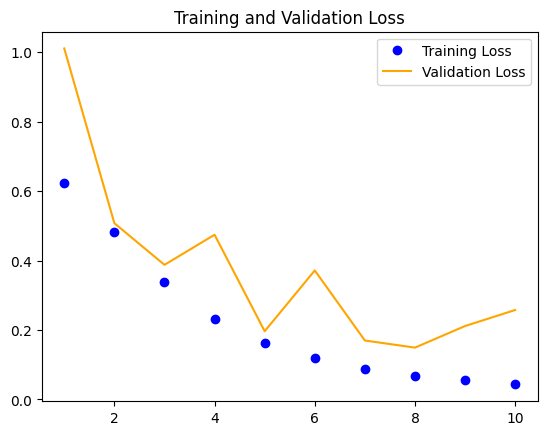

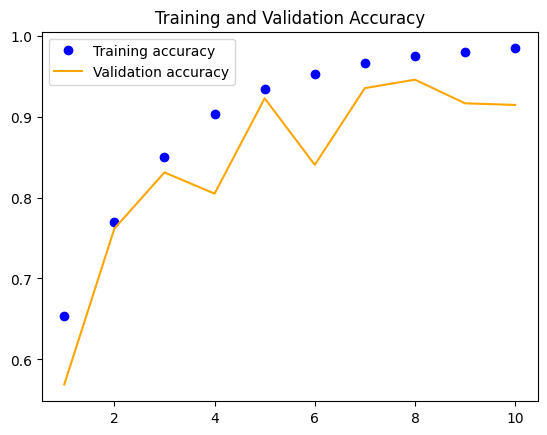

In [21]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

## Short EDA - Explorer Results Analysis

In [12]:
true_labels = []
predictions = []
num_images = 1000

# Obtener una muestra aleatoria de imágenes de cada conjunto de datos
selected_real_images = random.sample(real_images, min(num_images, len(real_images)))
selected_fake_images = random.sample(fake_images, min(num_images, len(fake_images)))

In [13]:
# Función para predecir una imagen
def predict_image(img_path, inference_func):
    img = image.load_img(img_path, color_mode="grayscale", target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.
    output = inference_func(tf.constant(img_array))
    prediction_value = output["output_0"].numpy()[0][0]
    return prediction_value

In [14]:
# Procesar las imágenes reales seleccionadas
for img_path in selected_real_images:
    true_labels.append(1)  # Etiqueta 1 para imágenes reales
    prediction_value = predict_image(img_path, inference_func)
    predictions.append(prediction_value)

# Procesar las imágenes falsas seleccionadas
for img_path in selected_fake_images:
    true_labels.append(0)  # Etiqueta 0 para imágenes falsas
    prediction_value = predict_image(img_path, inference_func)
    predictions.append(prediction_value)

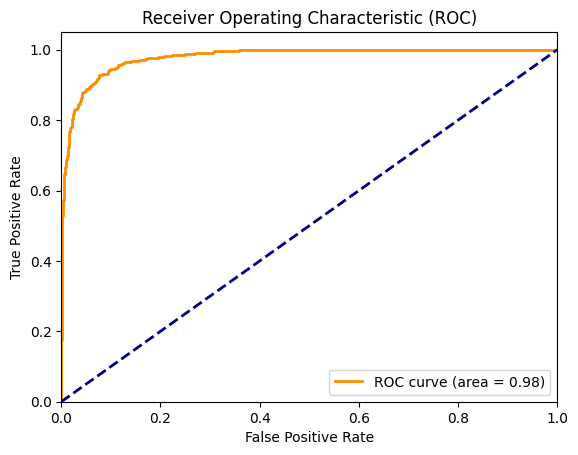

In [16]:
# Calcular la curva ROC
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Precision Recall Curve

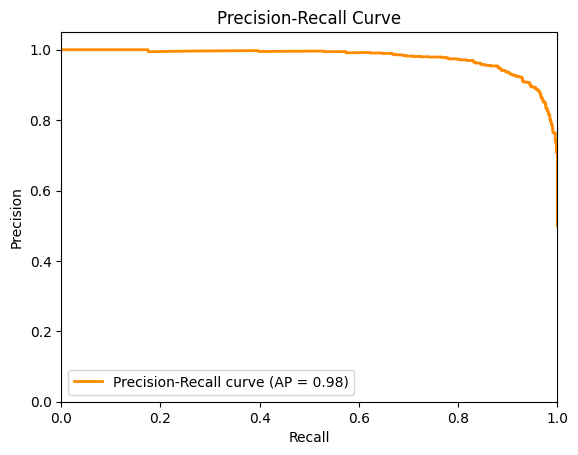

In [17]:
# Calcular la precisión y la exhaustividad
precision, recall, _ = precision_recall_curve(true_labels, predictions)

# Calcular el área bajo la curva de precisión-exhaustividad (AP)
average_precision = auc(recall, precision)

# Graficar la curva de precisión-exhaustividad
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

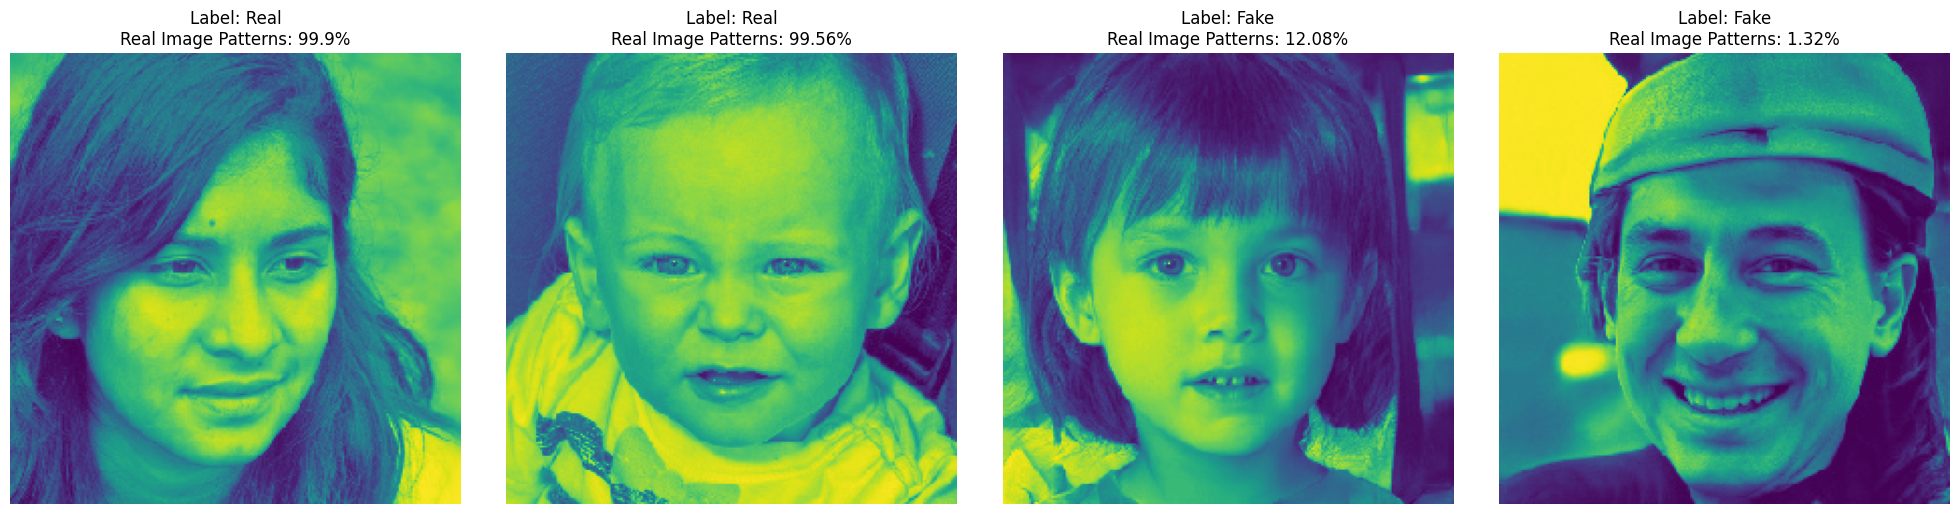

In [19]:
def show_inference(img_path, inference_func):
    # Cargar la imagen en escala de grises
    img = image.load_img(img_path, color_mode="grayscale", target_size=(224, 224))
    
    # Normalizar los píxeles de la imagen
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.
    
    # Realizar la inferencia
    output = inference_func(tf.constant(img_array))
    prediction_value = output["output_0"].numpy()[0][0]
    perc = round(prediction_value * 100, 2)
    
    # Determinar la etiqueta basada en la probabilidad
    label = "Real" if prediction_value > 0.5 else "Fake"
    
    return perc, prediction_value, label, img

img_path_real = '../dataset/real-vs-fake/test/real'
real_images = os.listdir(img_path_real)
selected_real_images = random.sample(real_images, 2)

img_path_fake = '../dataset/real-vs-fake/test/fake'
fake_images = os.listdir(img_path_fake)
selected_fake_images = random.sample(fake_images, 2)


fig, axes = plt.subplots(1, 4, figsize=(20, 5)) 

for i, img_path in enumerate(selected_real_images):
    perc, _, label, img = show_inference(os.path.join(img_path_real, img_path), inference_func)
    ax = axes[i]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label: {label}\nReal Image Patterns: {perc}%')

for i, img_path in enumerate(selected_fake_images):
    perc, _, label, img = show_inference(os.path.join(img_path_fake, img_path), inference_func)
    ax = axes[i+2]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label: {label}\nReal Image Patterns: {perc}%')

plt.tight_layout()
plt.show()
